### Import needed Libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import scipy.fftpack as sf

### Import QAM functions from QAM

In [2]:
import import_ipynb
import QAM


importing Jupyter notebook from QAM.ipynb


### Parameters for the Model

In [3]:
SNR=10
plot=1

# Upsampler Factor
K = 10

# Number of symbols
Ns = 256

# Roll-off factor
alpha = 0.3

# Bits per symbol
Bs = 3

# 16QAM Constellation vector
#QAM16 = [-1, -0.333, 0.333, 1]
QAM8 = [[-1, 1],[-1, -0.333, 0.333, 1]]

# Intermediary frequency
Fif = 2e6

# Sampling Rate
Fs = Fif*K/2


### Data bitstream generation

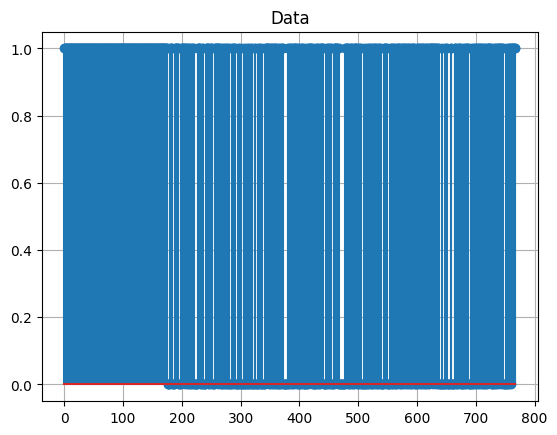

In [4]:
data = QAM.dataGenerator(Ns*Bs) #  Total Bits count
if plot == 1:
    plt.figure(0)
    plt.stem(data)
    plt.title('Data')
    plt.grid()

### Modulation

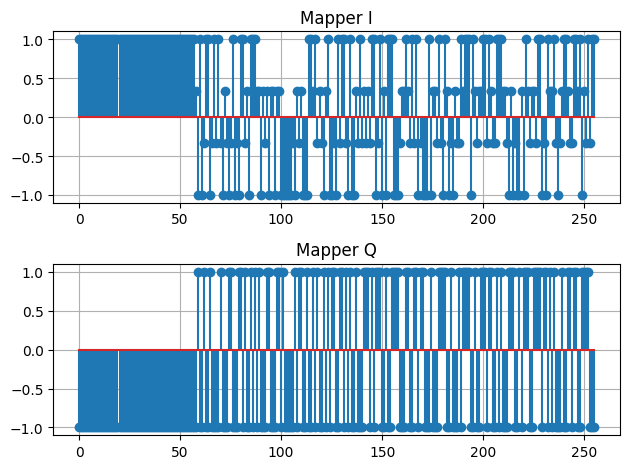

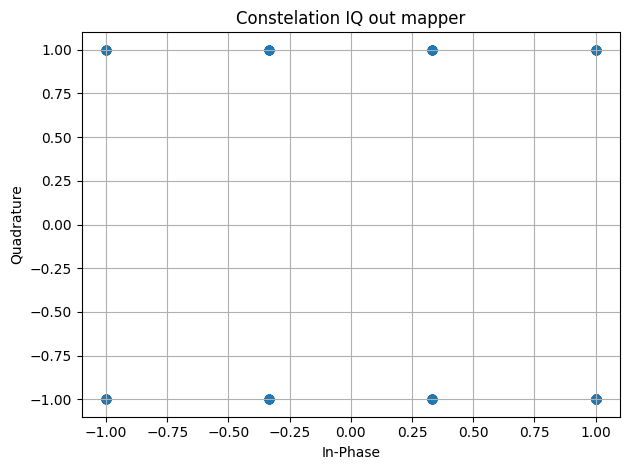

In [5]:

mapI,mapQ = QAM.Modulator8QAM(QAM8, data)

#print(mapQ,mapQ)
# print(mapI)
# print(mapQ)

if plot == 1:
    plt.figure(1)
    plt.subplot(2, 1, 1)
    plt.stem(mapI)
    plt.title('Mapper I')
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.stem(mapQ)
    plt.title('Mapper Q')
    plt.tight_layout()
    plt.grid()

    plt.figure(2)
    plt.scatter(mapI, mapQ)
    plt.title('Constelation IQ out mapper')
    plt.xlabel('In-Phase')
    plt.ylabel('Quadrature')
    plt.tight_layout()
    plt.grid()


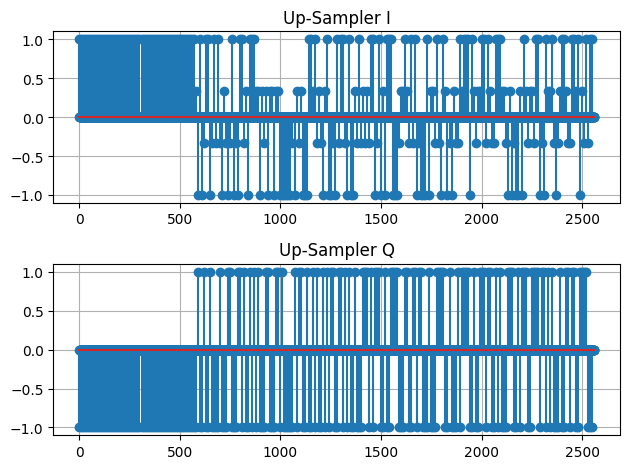

In [6]:
upI = QAM.Upsampler(Ns, K, mapI)
upQ = QAM.Upsampler(Ns, K, mapQ)


if plot == 1:
    plt.figure(3)
    plt.subplot(2, 1, 1)
    plt.stem(upI)
    plt.grid()
    plt.title('Up-Sampler I')
    plt.subplot(2, 1, 2)
    plt.stem(upQ)
    plt.title('Up-Sampler Q')
    plt.tight_layout()
    plt.grid()

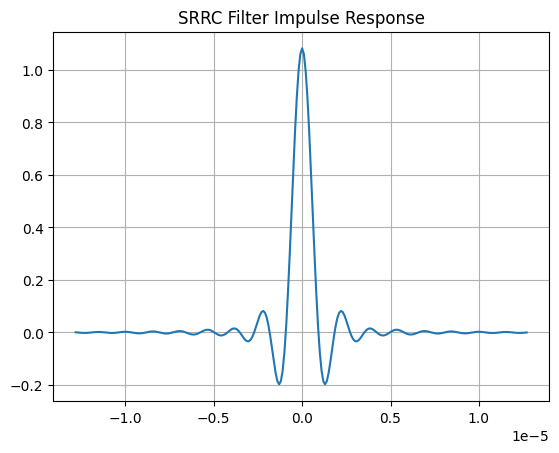

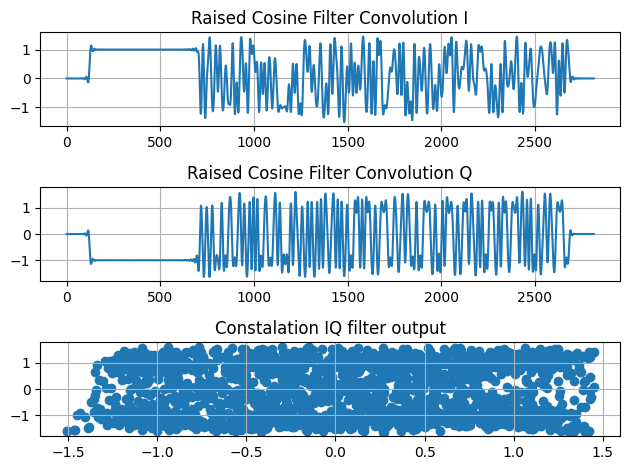

In [7]:
[shape_I, a, b] = QAM.PulseShapping(upI, Ns, alpha, Fif, Fs)
[shape_Q, a, b] = QAM.PulseShapping(upQ, Ns, alpha, Fif, Fs)

template = b

if plot == 1:
    plt.figure(4)
    plt.plot(a, b)
    plt.title('SRRC Filter Impulse Response')
    plt.grid()
    plt.figure(5)
    plt.subplot(3, 1, 1)
    plt.plot(shape_I)
    plt.title('Raised Cosine Filter Convolution I')
    plt.grid()
    plt.subplot(3, 1, 2)
    plt.plot(shape_Q)
    plt.title('Raised Cosine Filter Convolution Q')
    plt.grid()
    plt.subplot(3, 1, 3)
    plt.scatter(shape_I, shape_Q)
    plt.title('Constalation IQ filter output')
    plt.tight_layout()
    plt.grid()

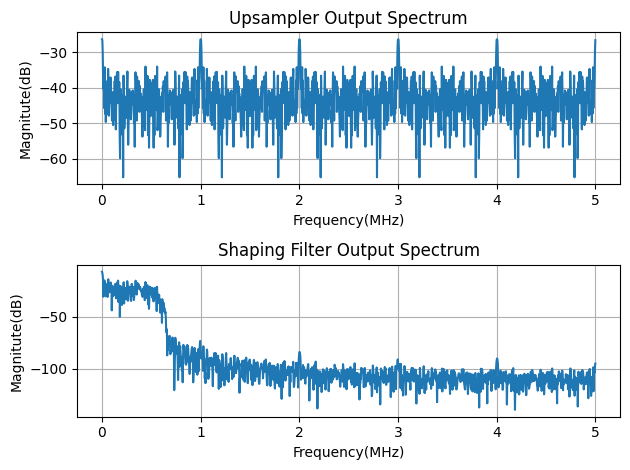

In [8]:
if plot == 1:
    X_f = abs(sf.fft(upI))
    l = np.size(upI)
    fr = (Fs/2)*np.linspace(0, 1, int(l/2))
    xl_m = (2/l)*abs(X_f[0:np.size(fr)])

    plt.figure(6)
    plt.subplot(2, 1, 1)
    plt.plot(fr/1e6, 20*np.log10(xl_m))
    plt.title('Upsampler Output Spectrum')
    plt.xlabel('Frequency(MHz)')
    plt.ylabel('Magnitute(dB)')
    plt.grid()
    plt.tight_layout()

    X_f2 = abs(sf.fft(shape_I))
    l2 = np.size(shape_I)
    fr2 = (Fs/2)*np.linspace(0, 1, int(l2/2))
    xl_m2 = (2/l2)*abs(X_f2[0:np.size(fr2)])

    plt.subplot(2, 1, 2)
    plt.plot(fr2/1e6, 20*np.log10(xl_m2))
    plt.title('Shaping Filter Output Spectrum')
    plt.xlabel('Frequency(MHz)')
    plt.ylabel('Magnitute(dB)')
    plt.grid()
    plt.tight_layout()

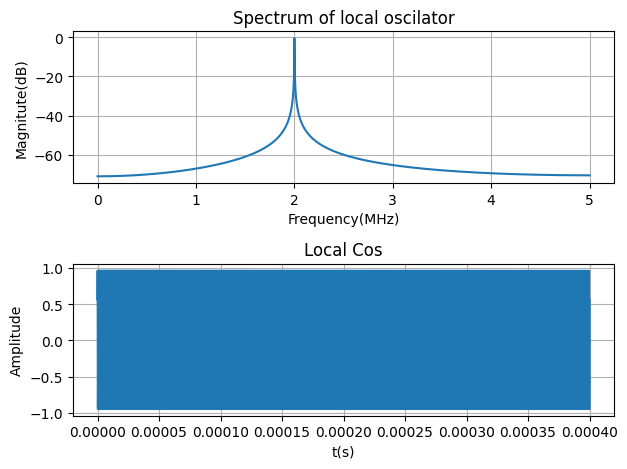

In [9]:
# Oscillator

delta_phase = np.random.normal(0, pi/3, 1)
delta_freq = np.random.normal(0, 20, 1)

(loCos_TX, t) = QAM.CarrierGen(0, 4e-4, 2 /
                                (Fif*K),  Fif + delta_freq, delta_phase + pi/2)
(loSin_TX, t) = QAM.CarrierGen(0, 4e-4, 2 /
                                (Fif*K),  Fif + delta_freq, delta_phase)

if plot == 1:
    X_f_1 = abs(sf.fft(loCos_TX))
    l_1 = np.size(loCos_TX)
    fr_1 = (Fs/2)*np.linspace(0, 1, int(l_1/2))
    xl_m_1 = (2/l_1)*abs(X_f_1[0:np.size(fr_1)])

    plt.figure(7)
    plt.subplot(2, 1, 1)
    plt.plot(fr_1/1e6, 20*np.log10(xl_m_1))
    plt.title('Spectrum of local oscilator')
    plt.xlabel('Frequency(MHz)')
    plt.ylabel('Magnitute(dB)')
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(t, loCos_TX)
    plt.title('Local Cos')
    plt.xlabel('t(s)')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.grid()

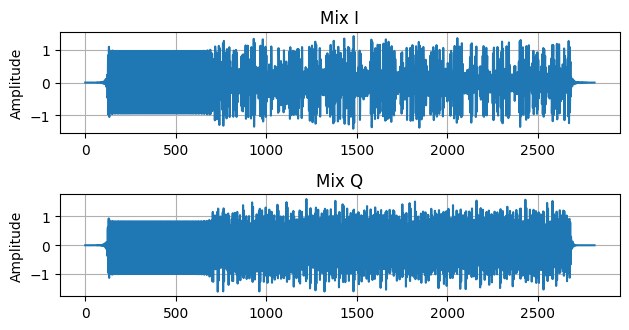

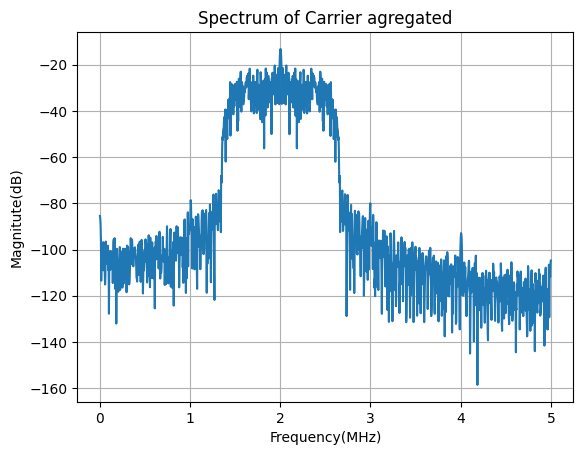

In [10]:
# Mixers

mixI = QAM.Mixer(shape_I, loCos_TX)
mixQ = QAM.Mixer(shape_Q,loSin_TX)

if plot == 1:
    plt.figure(8)
    plt.subplot(3, 1, 1)
    plt.plot(mixI)
    plt.title('Mix I')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(mixQ)
    plt.title('Mix Q')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.grid()
    
    seva = abs(sf.fft(mixI))
    nova = np.size(mixI)
    balti = (Fs/2)*np.linspace(0, 1, int(nova/2))
    druni = (2/nova)*abs(seva[0:np.size(balti)])
    
    plt.figure()
    plt.plot(balti/1e6, 20*np.log10(druni))
    plt.title('Spectrum of Carrier agregated')
    plt.xlabel('Frequency(MHz)')
    plt.ylabel('Magnitute(dB)')
    plt.grid()


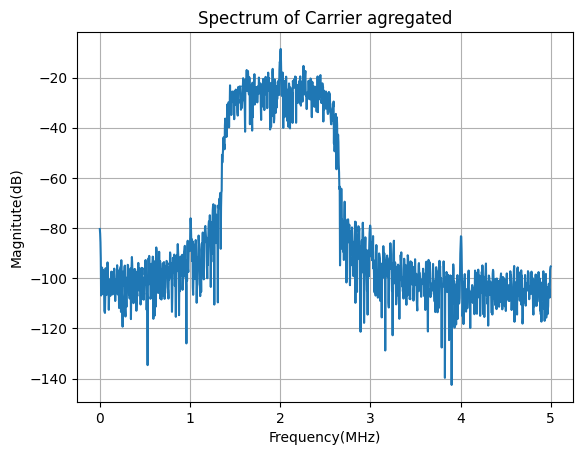

In [11]:
# Combiner

IF = QAM.combiner(mixI, mixQ)

# print(IF)

# with open("TransmitedData.txt", "w", newline="") as file:
#     for i in range(len(IF)):
#         file.write(str(IF[i]))


seva = abs(sf.fft(IF))
nova = np.size(IF)
balti = (Fs/2)*np.linspace(0, 1, int(nova/2))
druni = (2/nova)*abs(seva[0:np.size(balti)])

plt.figure()
plt.plot(balti/1e6, 20*np.log10(druni))
plt.title('Spectrum of Carrier agregated')
plt.xlabel('Frequency(MHz)')
plt.ylabel('Magnitute(dB)')
plt.grid()

np.save('OutputFiles/TransmittedData', IF)

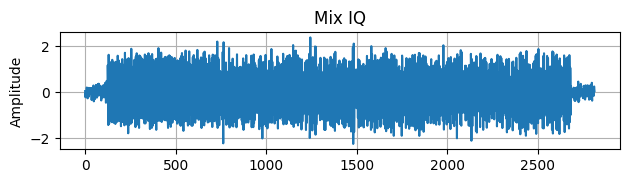

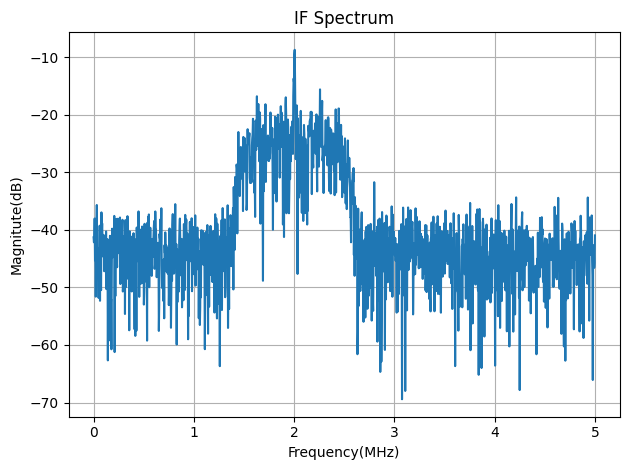

In [12]:
# Noise

IF_n = QAM.AWGN(IF, SNR)


if plot == 1:
    plt.subplot(3, 1, 3)
    plt.plot(IF_n)
    plt.title('Mix IQ')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.grid()

    X_f1 = abs(sf.fft(IF_n))
    l1 = np.size(IF_n)
    fr1 = (Fs/2)*np.linspace(0, 1, int(l1/2))
    xl_m1 = (2/l1)*abs(X_f1[0:np.size(fr1)])

    plt.figure(9)
    plt.plot(fr1/1e6, 20*np.log10(xl_m1))
    plt.title('IF Spectrum')
    plt.xlabel('Frequency(MHz)')
    plt.ylabel('Magnitute(dB)')
    plt.tight_layout()
    plt.grid()
    
    
    
np.save('OutputFiles/RecievedData', IF_n)

In [13]:
print("SINR value:",QAM.SINR(IF,IF_n),"dB")

SINR value: 12.792500516140532 dB


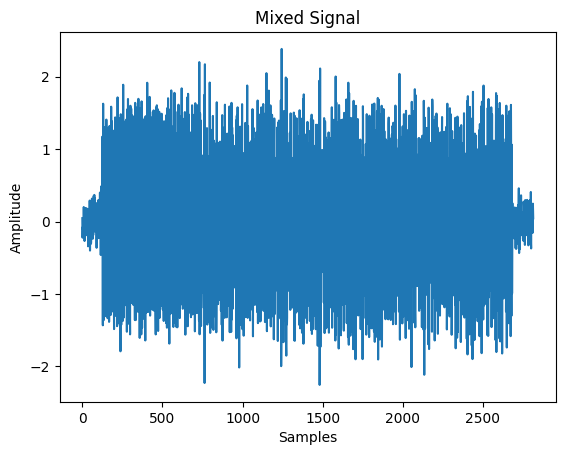

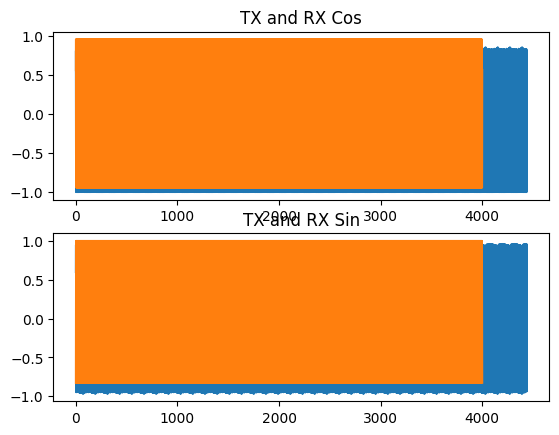

In [14]:
(loCos_RX, loSin_RX) = QAM.PLL(IF_n, Fs, len(loCos_TX), K/2)

if plot == 1:
    plt.figure(10)
    plt.plot(IF_n)
    plt.title('Mixed Signal')
    plt.xlabel('Samples')
    plt.ylabel('Amplitude')

    plt.figure(11)
    plt.subplot(2, 1, 1)
    plt.plot(loCos_RX)
    plt.plot(loCos_TX)
    plt.title("TX and RX Cos")
    plt.subplot(2, 1, 2)
    plt.plot(loSin_RX)
    plt.plot(loSin_TX)
    plt.title("TX and RX Sin")

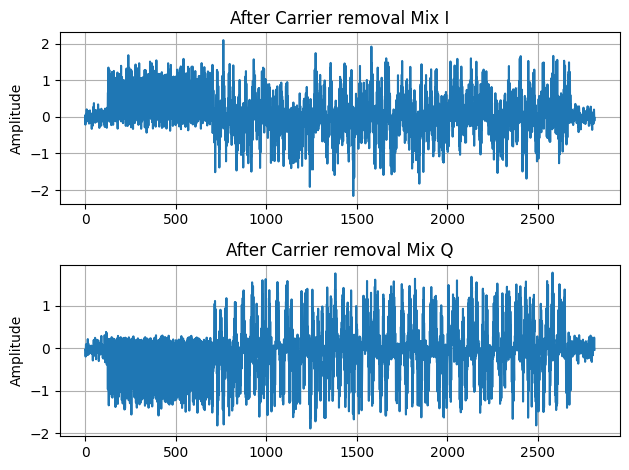

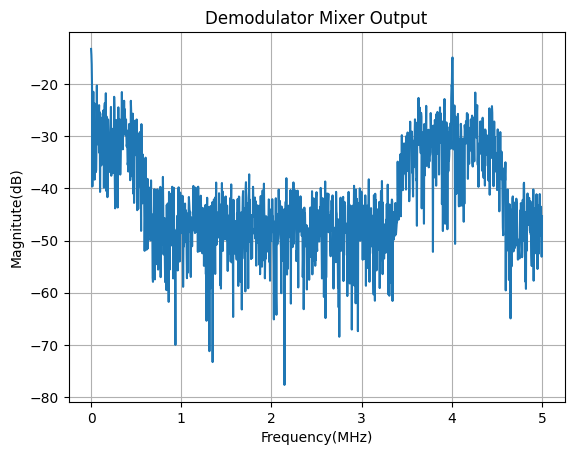

In [15]:
# Mixer

shape_I_demod = QAM.Mixer(IF_n, loCos_TX)
shape_Q_demod = QAM.Mixer(IF_n, loSin_TX)

if plot == 1:
    plt.figure(12)
    plt.subplot(2, 1, 1)
    plt.plot(shape_I_demod)
    plt.title('After Carrier removal Mix I')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.grid()

    plt.subplot(2, 1, 2)
    plt.plot(shape_Q_demod)
    plt.title('After Carrier removal Mix Q')
    plt.ylabel('Amplitude')
    plt.tight_layout()
    plt.grid()

    X_f3 = abs(sf.fft(shape_I_demod))
    l3 = np.size(shape_I_demod)
    fr3 = (Fs/2)*np.linspace(0, 1, int(l3/2))
    xl_m3 = (2/l3)*abs(X_f3[0:np.size(fr3)])

    plt.figure(13)
    plt.plot(fr3/1e6, 20*np.log10(xl_m3))
    plt.title('Demodulator Mixer Output')
    plt.xlabel('Frequency(MHz)')
    plt.ylabel('Magnitute(dB)')
    plt.grid()

/home/ceribro/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/ceribro/.local/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


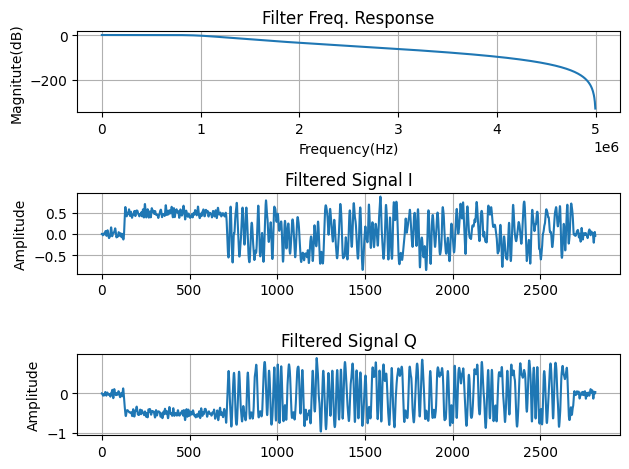

In [16]:
# Low Pass Filter (Butterworth)

fc = 1e6

[shape_I_demod_filt, W, h] = QAM.LPF(shape_I_demod, fc, Fs)
[shape_Q_demod_filt, W, h] = QAM.LPF(shape_Q_demod, fc, Fs)

if plot == 1:
    plt.figure(14)
    plt.subplot(3, 1, 1)
    plt.plot(W, 20*np.log10(h))
    plt.title('Filter Freq. Response')
    plt.xlabel('Frequency(Hz)')
    plt.ylabel('Magnitute(dB)')
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(shape_I_demod_filt)
    plt.title('Filtered Signal I')
    plt.tight_layout()
    plt.ylabel('Amplitude')
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(shape_Q_demod_filt)
    plt.title('Filtered Signal Q')
    plt.tight_layout()
    plt.ylabel('Amplitude')
    plt.grid()

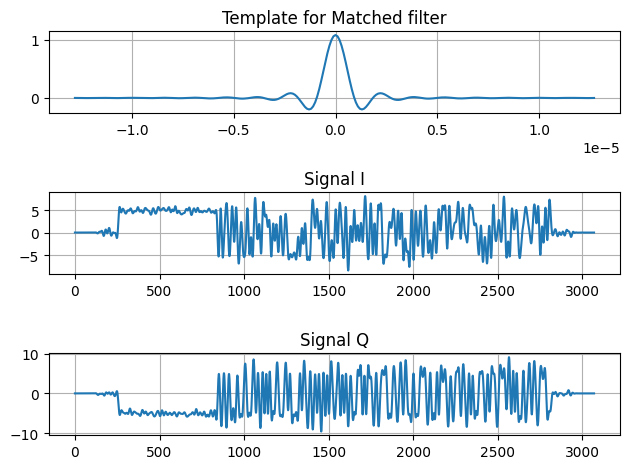

In [17]:

# Matched Filter

signal_I = QAM.MatchedFil(shape_I_demod_filt, template)
signal_Q = QAM.MatchedFil(shape_Q_demod_filt, template)



if plot == 1:
    plt.figure(15)
    plt.subplot(3, 1, 1)
    plt.plot(a,template)
    plt.title('Template for Matched filter')
    plt.tight_layout()
    plt.grid()

    plt.subplot(3, 1, 2)
    plt.plot(signal_I)
    plt.title('Signal I')
    plt.tight_layout()
    plt.grid()

    plt.subplot(3, 1, 3)
    plt.plot(signal_Q)
    plt.title('Signal Q')
    plt.tight_layout()
    plt.grid()


Cut_i =  440
Cut_f =  2360
Cut_i =  401
Cut_f =  2321


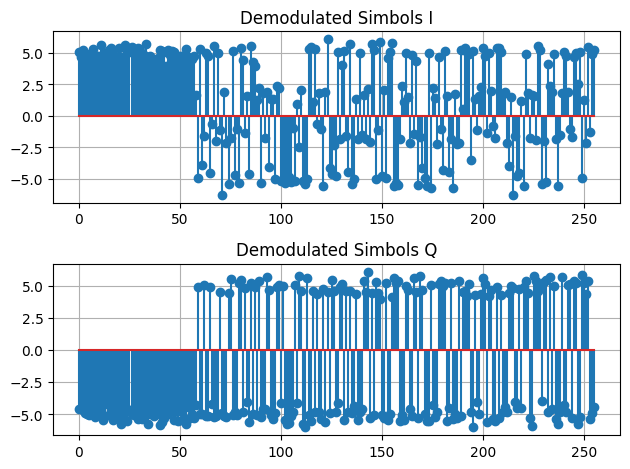

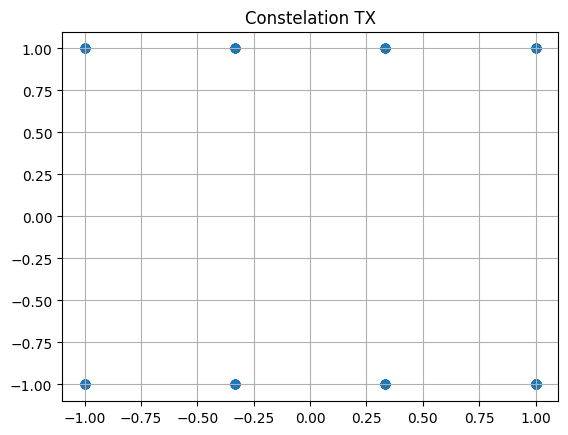

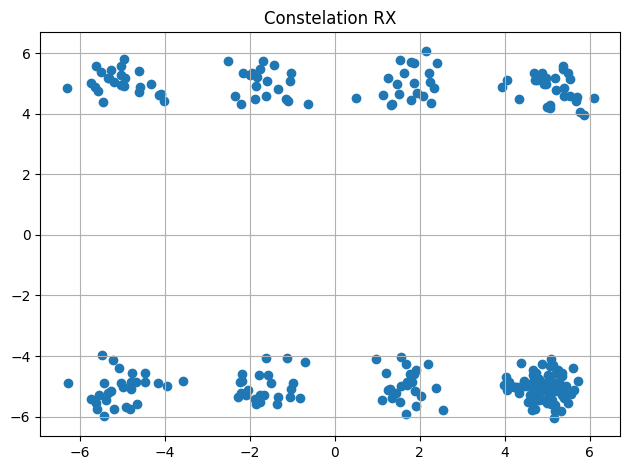

In [18]:

# Sampling - Gardner Algorithm

symbols_I = QAM.DownSamp(signal_I, len(data), K)
symbols_Q = QAM.DownSamp(signal_Q, len(data), K)

if plot == 1:
    plt.figure(16)
    plt.subplot(2, 1, 1)
    plt.stem(symbols_I)
    plt.title('Demodulated Simbols I')
    plt.grid()
    plt.subplot(2, 1, 2)
    plt.stem(symbols_Q)
    plt.title('Demodulated Simbols Q')
    plt.grid()
    plt.tight_layout()

    plt.figure(17)
    plt.scatter(mapI, mapQ)
    plt.title('Constelation TX')
    plt.grid()
    plt.figure(18)
    plt.scatter(symbols_I, symbols_Q)
    plt.title('Constelation RX')
    plt.grid()
    plt.tight_layout()

In [19]:

# Demodulator

data_demod = QAM.demodulator8QAM(symbols_I, symbols_Q, len(data))


# print("data demodulated size",data_demod)
# print("data original",data)

error = 0.0

for i in range(len(data)):
    if data_demod[i] != data[i]:
        error = error + 1.0

BER = (error*100)/(len(data))

print("\n\n\n")

print("BER:", BER, "%")

print("Phase Offset Through AWGN Channel:", delta_phase/pi, "pi rad")
print("Frequency Offset AWGN Channel:", delta_freq, "Hz")

print("\n\n\n")

with open("DemodulatedBits.txt", "w", newline="") as file:
    for i in range(len(data_demod)):
        file.write(str(data_demod[i]))







BER: 0.0 %
Phase Offset Through AWGN Channel: [-0.30942686] pi rad
Frequency Offset AWGN Channel: [1.57872306] Hz




